$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

## Neural Network Code

We began by starting with a ```NeuralNetwork``` class that was written by Dr. Charles Anderson in previous lecture for CS 445 - Machine Learning. We then took that class and we have created a new version of it which we can use to break up and test the data from our Heroes of the Storm demos. This data has been parsed into arrays so that we can easily feed them through this code and gather significant information about the data sets. We can then take this data and we can calculate, display, and discuss the teams results.

Again, we begin with the ```NeuralNetwork``` class defined in lecture notes 09 of CS 445 Machine Learning with Dr. Anderson. We will also need mlutilities.py which was written by him and was initially imported from:

http://www.cs.colostate.edu/~anderson/cs445/notebooks/mlutilities09.tar

In [1]:
# Functions for use in CS445, Introduction to Machine Learning
# Spring, 2018
# by Chuck Anderson, for CS445 
# http://www.cs.colostate.edu/~anderson
# You may use, but please credit the source.
#
# Added to this notebook as code for use in
# CS440, Introduction to Artificial Intelligence
# Fall, 2018
# ALL credit goes to Dr. Anderson, as outlined above
# or the individuals cited throughout the code 
      
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch  # for Arc
import matplotlib.collections as pltcoll
import pandas as pd
import sys
from math import sqrt, ceil
floatPrecision = sys.float_info.epsilon

def trainValidateTestKFolds(trainf, evaluatef, X, T, parameterSets, nFolds=5,
                            shuffle=False, verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    isNewBetterThanOld = lambda new,old: new < old
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("trainValidateTestKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds, nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts, stops))
        
    # Repeat with testFold taking each single fold, one at a time
    results = []
    for testFold in range(nFolds):
        # Leaving the testFold out, for each validate fold, train on remaining
        # folds and evaluate on validate fold. Collect theseRepeat with validate
        # Construct Xtest and Ttest
        a,b = startsStops[testFold]
        rows = rowIndices[a:b]
        Xtest = X[rows, :]
        Ttest = T[rows, :]

        bestParms = None
        for parms in parameterSets:
            # trainEvaluationSum = 0
            validateEvaluationSum = 0
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # Construct Xtrain and Ttrain
                trainFolds = np.setdiff1d(range(nFolds), [testFold, validateFold])
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows, :]
                Ttrain = T[rows, :]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows, :]
                Tvalidate = T[rows, :]

                model = trainf(Xtrain, Ttrain, parms)
                # trainEvaluationSum += evaluatef(model,Xtrain,Train)
                validateEvaluationSum += evaluatef(model, Xvalidate, Tvalidate)
            validateEvaluation = validateEvaluationSum / (nFolds-1)
            if verbose:
                if hasattr(model, 'bestIteration') and model.bestIteration is not None:
                    print('{} Val {:.3f} Best Iter {:d}'.format(parms, validateEvaluation, model.bestIteration))
                else:
                    print('{} Val {:.3f}'.format(parms, validateEvaluation))

            if bestParms is None or isNewBetterThanOld(validateEvaluation, bestValidationEvaluation): 
                bestParms = parms
                bestValidationEvaluation = validateEvaluation
                if verbose:
                    print('New best')
                # trainEvaluation = trainEvaluationSum / (nFolds-1)

        newXtrain = np.vstack((Xtrain, Xvalidate))
        newTtrain = np.vstack((Ttrain, Tvalidate))

        model = trainf(newXtrain, newTtrain, bestParms)
        trainEvaluation = evaluatef(model, newXtrain, newTtrain)
        testEvaluation = evaluatef(model, Xtest, Ttest)

        # resultThisTestFold = [bestParms, trainEvaluation,
        #                       bestValidationEvaluation, testEvaluation]
        resultThisTestFold = [nFolds, testFold+1, bestParms, trainEvaluation, bestValidationEvaluation, testEvaluation]
        results.append(resultThisTestFold)
        print(pd.DataFrame(results,
                           columns=('nFolds',
                                    'Test Fold',
                                    'Best Parameters',
                                    'Train Accuracy',
                                    'Validation Accuracy',
                                    'Test Accuracy')))
        # print('{}/{}'.format(testFold+1, nFolds), end=' ', flush=True)
    return pd.DataFrame(results,
                        columns=('nFolds',
                                 'Test Fold',
                                 'Best Parameters',
                                 'Train Accuracy',
                                 'Validation Accuracy',
                                 'Test Accuracy'))

######################################################################

def draw(Vs, W, inputNames=None, outputNames=None, gray=False):

    def isOdd(x):
        return x % 2 != 0

    W = Vs + [W]
    nLayers = len(W)

    # calculate xlim and ylim for whole network plot
    #  Assume 4 characters fit between each wire
    #  -0.5 is to leave 0.5 spacing before first wire
    xlim = max(map(len, inputNames))/4.0 if inputNames else 1
    ylim = 0

    for li in range(nLayers):
        ni, no = W[li].shape  # no means number outputs this layer
        if not isOdd(li):
            ylim += ni + 0.5
        else:
            xlim += ni + 0.5

    ni, no = W[nLayers-1].shape
    if isOdd(nLayers):
        xlim += no + 0.5
    else:
        ylim += no + 0.5

    # Add space for output names
    if outputNames:
        if isOdd(nLayers):
            ylim += 0.25
        else:
            xlim += round(max(map(len,outputNames))/4.0)

    ax = plt.gca()

    character_width_factor = 0.07
    padding = 2
    if inputNames:
        x0 = max([1, max(map(len, inputNames)) * (character_width_factor * 3.5)])
    else:
        x0 = 1
    y0 = 0  # to allow for constant input to first layer
    # First Layer
    if inputNames:
        y = 0.55
        for n in inputNames:
            y += 1
            ax.text(x0 - (character_width_factor * padding), y, n, horizontalalignment="right", fontsize=20)

    patches = []
    for li in range(nLayers):
        thisW = W[li]
        maxW = np.max(np.abs(thisW))
        ni, no = thisW.shape
        if not isOdd(li):
            # Even layer index. Vertical layer. Origin is upper left.
            # Constant input
            ax.text(x0-0.2, y0+0.5, '1', fontsize=20)
            for i in range(ni):
                ax.plot((x0, x0+no-0.5), (y0+i+0.5, y0+i+0.5), color='gray')
            # output lines
            for i in range(no):
                ax.plot((x0+1+i-0.5, x0+1+i-0.5), (y0, y0+ni+1), color='gray')
            # cell "bodies"
            xs = x0 + np.arange(no) + 0.5
            ys = np.array([y0+ni+0.5]*no)
            for x, y in zip(xs, ys):
                patches.append(pltpatch.RegularPolygon((x, y-0.4), 3, 0.3, 0, color ='#555555'))
            # weights
            if gray:
                colors = np.array(["black", "gray"])[(thisW.flat >= 0)+0]
            else:
                colors = np.array(["red", "green"])[(thisW.flat >= 0)+0]
            xs = np.arange(no) + x0+0.5
            ys = np.arange(ni) + y0 + 0.5
            coords = np.meshgrid(xs, ys)
            for x, y, w, c in zip(coords[0].flat, coords[1].flat,
                                  np.abs(thisW/maxW).flat, colors):
                patches.append(pltpatch.Rectangle((x-w/2, y-w/2), w, w, color=c))
            y0 += ni + 1
            x0 += -1  # shift for next layer's constant input
        else:
            # Odd layer index. Horizontal layer. Origin is upper left.
            # Constant input
            ax.text(x0+0.5, y0-0.2, '1', fontsize=20)
            # input lines
            for i in range(ni):
                ax.plot((x0+i+0.5,  x0+i+0.5), (y0, y0+no-0.5), color='gray')
            # output lines
            for i in range(no):
                ax.plot((x0, x0+ni+1), (y0+i+0.5, y0+i+0.5), color='gray')
            # cell "bodies"
            xs = np.array([x0 + ni + 0.5] * no)
            ys = y0 + 0.5 + np.arange(no)
            for x, y in zip(xs, ys):
                patches.append(pltpatch.RegularPolygon((x-0.4, y), 3, 0.3, -np.pi/2, color ='#555555'))
            # weights
            if gray:
                colors = np.array(["black", "gray"])[(thisW.flat >= 0)+0]
            else:
                colors = np.array(["red", "green"])[(thisW.flat >= 0)+0]
            xs = np.arange(ni)+x0 + 0.5
            ys = np.arange(no)+y0 + 0.5
            coords = np.meshgrid(xs, ys)
            for x, y, w, c in zip(coords[0].flat, coords[1].flat,
                                  np.abs(thisW/maxW).flat, colors):
                patches.append(pltpatch.Rectangle((x-w/2, y-w/2), w, w, color=c))
            x0 += ni + 1
            y0 -= 1  # shift to allow for next layer's constant input

    collection = pltcoll.PatchCollection(patches, match_original=True)
    ax.add_collection(collection)

    # Last layer output labels
    if outputNames:
        if isOdd(nLayers):
            x = x0+1.5
            for n in outputNames:
                x += 1
                ax.text(x, y0+0.5, n, fontsize=20)
        else:
            y = y0+0.6
            for n in outputNames:
                y += 1
                ax.text(x0+0.2, y, n, fontsize=20)
    ax.axis([0, xlim, ylim, 0])
    ax.axis('off')


######################################################################
### Scaled Conjugate Gradient algorithm from
###  "A Scaled Conjugate Gradient Algorithm for Fast Supervised Learning"
###  by Martin F. Moller
###  Neural Networks, vol. 6, pp. 525-533, 1993
###
###  Adapted by Chuck Anderson from the Matlab implementation by Nabney
###   as part of the netlab library.
###
###  Call as   scg()  to see example use.

def scg(x, f, gradf, *fargs, **params):
    """scg:
    Example:
    def parabola(x,xmin,s):
        d = x - xmin
        return np.dot( np.dot(d.T, s), d)
    def parabolaGrad(x,xmin,s):
        d = x - xmin
        return 2 * np.dot(s, d)
    center = np.array([5,5])
    S = np.array([[5,4],[4,5]])
    firstx = np.array([-1.0,2.0])
    r = scg(firstx, parabola, parabolaGrad, center, S,
            xPrecision=0.001, nIterations=1000)
    print('Optimal: point',r[0],'f',r[1])"""

    evalFunc = params.pop("evalFunc",lambda x: "Eval "+str(x))
    nIterations = params.pop("nIterations",1000)
    xPrecision = params.pop("xPrecision",0) 
    fPrecision = params.pop("fPrecision",0)
    xtracep = params.pop("xtracep",False)
    ftracep = params.pop("ftracep",False)
    verbose = params.pop("verbose",False)
    iterationVariable = params.pop("iterationVariable",None)

### from Nabney's netlab matlab library
  
    nvars = len(x)
    sigma0 = 1.0e-6
    fold = f(x, *fargs)
    fnow = fold
    gradnew = gradf(x, *fargs)
    gradold = copy(gradnew)
    d = -gradnew				# Initial search direction.
    success = True				# Force calculation of directional derivs.
    nsuccess = 0				# nsuccess counts number of successes.
    beta = 1.0e-6				# Initial scale parameter. Lambda in Moeller.
    betamin = 1.0e-15 			# Lower bound on scale.
    betamax = 1.0e20			# Upper bound on scale.
    j = 1				# j counts number of iterations.
    
    if xtracep:
        xtrace = np.zeros((nIterations+1,len(x)))
        xtrace[0,:] = x
    else:
        xtrace = None

    if ftracep:
        ftrace = np.zeros(nIterations+1)
        ftrace[0] = fold
    else:
        ftrace = None
        
    ### Main optimization loop.
    while j <= nIterations:

        # Calculate first and second directional derivatives.
        if success:
            mu = np.dot(d, gradnew)
            if np.isnan(mu): print("mu is NaN")
            if mu >= 0:
                d = -gradnew
                mu = np.dot(d, gradnew)
            kappa = np.dot(d, d)
            if False and kappa < floatPrecision:
                print( kappa)
                return {'x':x, 'f':fnow, 'nIterations':j, 'xtrace':xtrace[:j,:] if xtracep else None, 
                        'ftrace':ftrace[:j] if ftracep else None,
                        'reason':"limit on machine precision"}
            sigma = sigma0/sqrt(kappa)
            xplus = x + sigma * d
            gplus = gradf(xplus, *fargs)
            theta = np.dot(d, gplus - gradnew)/sigma

        ## Increase effective curvature and evaluate step size alpha.
        delta = theta + beta * kappa
        if np.isnan(delta): print("delta is NaN")
        if delta <= 0:
            delta = beta * kappa
            beta = beta - theta/kappa
        alpha = -mu/delta
        
        ## Calculate the comparison ratio.
        xnew = x + alpha * d
        fnew = f(xnew, *fargs)
        Delta = 2 * (fnew - fold) / (alpha*mu)
        # if np.isnan(Delta):
        #     pdb.set_trace()
        if not np.isnan(Delta) and Delta  >= 0:
            success = True
            nsuccess += 1
            x = xnew
            fnow = fnew
        else:
            success = False
            fnow = fold

        if verbose and j % max(1,ceil(nIterations/10)) == 0:
            print("SCG: Iteration",j,"fValue",evalFunc(fnow),"Scale",beta)
            
        if xtracep:
            xtrace[j,:] = x
        if ftracep:
            ftrace[j] = fnow
            
        if success:
            ## Test for termination

            if max(abs(alpha*d)) < xPrecision:
                return {'x':x, 'f':fnow, 'nIterations':j, 'xtrace':xtrace[:j,:] if xtracep else None, 
                        'ftrace':ftrace[:j] if ftracep else None,
                        'reason':"limit on x Precision"}
            elif abs(fnew-fold) < fPrecision:
                return {'x':x, 'f':fnow, 'nIterations':j, 'xtrace':xtrace[:j,:] if xtracep else None, 
                        'ftrace':ftrace[:j] if ftracep else None,
                        'reason':"limit on f Precision"}
            else:
                ## Update variables for new position
                fold = fnew
                gradold = gradnew
                gradnew = gradf(x, *fargs)
                ## If the gradient is zero then we are done.
                if np.dot(gradnew, gradnew) == 0:
                    return {'x':x, 'f':fnow, 'nIterations':j, 'xtrace':xtrace[:j,:] if xtracep else None, 'ftrace':ftrace[:j],
                            'reason':"zero gradient"}

        ## Adjust beta according to comparison ratio.
        if np.isnan(Delta) or Delta < 0.25:
            beta = min(4.0*beta, betamax)
        elif Delta > 0.75:
            beta = max(0.5*beta, betamin)

        ## Update search direction using Polak-Ribiere formula, or re-start 
        ## in direction of negative gradient after nparams steps.
        if nsuccess == nvars:
            d = -gradnew
            nsuccess = 0
        elif success:
            gamma = np.dot(gradold - gradnew, gradnew/mu)
            d = gamma * d - gradnew
        j += 1
        if iterationVariable is not None:
            iterationVariable.value = j

        ## If we get here, then we haven't terminated in the given number of 
        ## iterations.

    return {'x':x, 'f':fnow, 'nIterations':j, 'xtrace':xtrace[:j,:] if xtracep else None, 'ftrace':ftrace[:j],
            'reason':"did not converge"}

######################################################################
### steepest
def steepest(x, f, gradf, *fargs, **params):
    """steepest:
    Example:
    def parabola(x,xmin,s):
        d = x - xmin
        return np.dot( np.dot(d.T, s), d)
    def parabolaGrad(x,xmin,s):
        d = x - xmin
        return 2 * np.dot(s, d)
    center = np.array([5,5])
    S = np.array([[5,4],[4,5]])
    firstx = np.array([-1.0,2.0])
    r = steepest(firstx, parabola, parabolaGrad, center, S,
                 stepsize=0.01,xPrecision=0.001, nIterations=1000)
    print('Optimal: point',r[0],'f',r[1])"""

    stepsize= params.pop("stepsize",0.1)
    evalFunc = params.pop("evalFunc",lambda x: "Eval "+str(x))
    nIterations = params.pop("nIterations",1000)
    xPrecision = params.pop("xPrecision", 1.e-8)  # 1.e-8 is a default value
    fPrecision = params.pop("fPrecision", 1.e-8)
    xtracep = params.pop("xtracep",False)
    ftracep = params.pop("ftracep",False)

    xtracep = True
    ftracep = True
    
    i = 1
    if xtracep:
        xtrace = np.zeros((nIterations+1,len(x)))
        xtrace[0,:] = x
    else:
        xtrace = None
    oldf = f(x,*fargs)
    if ftracep:
        ftrace = np.zeros(nIterations+1)
        ftrace[0] = f(x,*fargs)
    else:
        ftrace = None
  
    while i <= nIterations:
        g = gradf(x,*fargs)
        newx = x - stepsize * g
        newf = f(newx,*fargs)
        if (i % (nIterations/10)) == 0:
            print("Steepest: Iteration",i,"Error",evalFunc(newf))
        if xtracep:
            xtrace[i,:] = newx
        if ftracep:
            ftrace[i] = newf
        if np.any(newx == np.nan) or newf == np.nan:
            raise ValueError("Error: Steepest descent produced newx that is NaN. Stepsize may be too large.")
        if np.any(newx==np.inf) or  newf==np.inf:
            raise ValueError("Error: Steepest descent produced newx that is NaN. Stepsize may be too large.")
        if max(abs(newx - x)) < xPrecision:
            return {'x':newx, 'f':newf, 'nIterations':i, 'xtrace':xtrace[:i,:], 'ftrace':ftrace[:i],
                    'reason':"limit on x precision"}
        if abs(newf - oldf) < fPrecision:
            return {'x':newx, 'f':newf, 'nIterations':i, 'xtrace':xtrace[:i,:], 'ftrace':ftrace[:i],
                    'reason':"limit on f precision"}
        x = newx
        oldf = newf
        i += 1

    return {'x':newx, 'f':newf, 'nIterations':i, 'xtrace':xtrace[:i,:], 'ftrace':ftrace[:i], 'reason':"did not converge"}



if __name__ == "__main__":

    def parabola(x,xmin,s):
        d = x - xmin
        return np.dot( np.dot(d.T, s), d)
    def parabolaGrad(x,xmin,s):
        d = x - xmin
        return 2 * np.dot(s, d)
    center = np.array([5,5])
    S = np.array([[5,4],[4,5]])

    firstx = np.array([-1.0,2.0])
    r = scg(firstx, parabola, parabolaGrad, center, S,
            xPrecision=0.001, nIterations=1000)

    print('Stopped after',r['nIterations'],'iterations. Reason for stopping:',r['reason'])
    print('Optimal: point =',r['x'],'f =',r['f'])

C:\Users\inqui\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Stopped after 3 iterations. Reason for stopping: limit on x Precision
Optimal: point = [4.9999997  5.00000031] f = 1.853198133182618e-13


As stated above, we started with our initial neural network code (provided by Dr. Anderson). We then defined a new class named NeuralNetworkReLU that extends NeuralNetwork and simply defines new implementations of activation and activationDerivative that implement the ReLU activation function instead of the tanh activation function. 

This is because we wanted to test out both activation functions, tanh and ReLU, for our Neural Networks in order to compare the results and this gave us the ability to test both. 

We choose these two functions, because two of us have worked with them in past projects and we were more comfortable with using them. However, we could have just as easily used something like the Swish or similar "new" implementations. 

In [2]:
# Neural Network code was initially provided 
# for use in CS445, Introduction to Machine Learning
# Spring, 2018
# by Chuck Anderson, for CS445 
# http://www.cs.colostate.edu/~anderson
# You may use, but please credit the source.
#
# Added to this notebook as code for use in
# CS440, Introduction to Artificial Intelligence
# Fall, 2018
# ALL credit goes to Dr. Anderson, as outlined above
# or individuals cited throughout the code
# 
# Some edits have been made by this team as defined 
# in the jupyter notebook this was found in. 

import numpy as np
import mlutilities as ml
import matplotlib.pyplot as plt
from copy import copy
import time
import random


class NeuralNetwork(object):

    def __init__(self, ni, nhs, no):
        if isinstance(nhs, list) or isinstance(nhs, tuple):
            nihs = [ni] + list(nhs)
        else:
            if nhs > 0:
                nihs = [ni, nhs]
                nhs = [nhs]
            else:
                nihs = [ni]
                nhs = []
        if len(nihs) > 1:
            self.Vs = [1/np.sqrt(nihs[i]) *
                       np.random.uniform(-1, 1, size=(1+nihs[i], nihs[i+1])) for i in range(len(nihs)-1)]
            self.W = 1/np.sqrt(nhs[-1]) * np.random.uniform(-1, 1, size=(1+nhs[-1], no))
        else:
            self.Vs = []
            self.W = 1/np.sqrt(ni) * np.random.uniform(-1, 1, size=(1+ni, no))
        self.ni, self.nhs, self.no = ni, nhs, no
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.trained = False
        self.reason = None
        self.errorTrace = None
        self.numberOfIterations = None
        self.trainingTime = None

    def __repr__(self):
        str = 'NeuralNetwork({}, {}, {})'.format(self.ni, self.nhs, self.no)
        # str += '  Standardization parameters' + (' not' if self.Xmeans == None else '') + ' calculated.'
        if self.trained:
            str += '\n   Network was trained for {} iterations that took {:.4f} seconds. Final error is {}.'.format(self.numberOfIterations, self.getTrainingTime(), self.errorTrace[-1])
        else:
            str += '  Network is not trained.'
        return str

    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans

    def _pack(self, Vs, W):
        return np.hstack([V.flat for V in Vs] + [W.flat])

    def _unpack(self, w):
        first = 0
        numInThisLayer = self.ni
        for i in range(len(self.Vs)):
            self.Vs[i][:] = w[first:first+(numInThisLayer+1)*self.nhs[i]].reshape((numInThisLayer+1, self.nhs[i]))
            first += (numInThisLayer+1) * self.nhs[i]
            numInThisLayer = self.nhs[i]
        self.W[:] = w[first:].reshape((numInThisLayer+1, self.no))

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        # Do forward pass through all layers
        Zprev = X
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = self.activation(Zprev @ V[1:, :] + V[0:1, :])  # handling bias weight without adding column of 1's
        Y = Zprev @ self.W[1:, :] + self.W[0:1, :]
        return 0.5 * np.mean((T-Y)**2)

    def _gradientF(self, w, X, T):
        self._unpack(w)
        # Do forward pass through all layers
        Zprev = X
        Z = [Zprev]
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = self.activation(Zprev @ V[1:, :] + V[0:1, :])
            Z.append(Zprev)
        Y = Zprev @ self.W[1:, :] + self.W[0:1, :]
        # Do backward pass, starting with delta in output layer
        delta = -(T - Y) / (X.shape[0] * T.shape[1])
        dW = np.vstack((np.ones((1, delta.shape[0])) @ delta, 
                        Z[-1].T @ delta))
        dVs = []
        delta = self.activationDerivative(Z[-1]) * (delta @ self.W[1:, :].T)
        for Zi in range(len(self.nhs), 0, -1):
            Vi = Zi - 1  # because X is first element of Z
            dV = np.vstack((np.ones((1, delta.shape[0])) @ delta,
                            Z[Zi-1].T @ delta))
            dVs.insert(0, dV)
            delta = (delta @ self.Vs[Vi][1:, :].T) * self.activationDerivative(Z[Zi-1])
        return self._pack(dVs, dW)

    def train(self, X, T, nIterations=100, verbose=False,
              weightPrecision=0, errorPrecision=0, saveWeightsHistory=False):
        
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1
        X = self._standardizeX(X)

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        T = self._standardizeT(T)

        startTime = time.time()

        scgresult = ml.scg(self._pack(self.Vs, self.W),
                            self._objectiveF, self._gradientF,
                            X, T,
                            xPrecision=weightPrecision,
                            fPrecision=errorPrecision,
                            nIterations=nIterations,
                            verbose=verbose,
                            ftracep=True,
                            xtracep=saveWeightsHistory)

        self._unpack(scgresult['x'])
        self.reason = scgresult['reason']
        self.errorTrace = np.sqrt(scgresult['ftrace']) # * self.Tstds # to _unstandardize the MSEs
        self.numberOfIterations = len(self.errorTrace)
        self.trained = True
        self.weightsHistory = scgresult['xtrace'] if saveWeightsHistory else None
        self.trainingTime = time.time() - startTime
        return self

    def use(self, X, allOutputs=False):
        Zprev = self._standardizeX(X)
        Z = [Zprev]
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = self.activation(Zprev @ V[1:, :] + V[0:1, :])
            Z.append(Zprev)
        Y = Zprev @ self.W[1:, :] + self.W[0:1, :]
        Y = self._unstandardizeT(Y)
        return (Y, Z[1:]) if allOutputs else Y

    def getNumberOfIterations(self):
        return self.numberOfIterations

    def getErrors(self):
        return self.errorTrace

    def getTrainingTime(self):
        return self.trainingTime

    def getWeightsHistory(self):
        return self.weightsHistory

    def draw(self, inputNames=None, outputNames=None, gray=False):
        ml.draw(self.Vs, self.W, inputNames, outputNames, gray)

    def activation(self, weighted_sum):
        return np.tanh(weighted_sum)
    
    def activationDerivative(self, activation_value):
        return 1 - activation_value * activation_value
    

class NeuralNetworkReLU(NeuralNetwork):
    # the following is a really fancy and quick numpy way of using  
    # ReLU (if x <= 0 return 0 else return x) as an activation function
    # taken from a reply by @Sid on stackoverflow.com
    def activation(self, weighted_sum):
        weighted_sum = np.array(weighted_sum)
        weighted_sum[weighted_sum<=0] = 0
 
        return weighted_sum
    
    def activationDerivative(self, activation_value):
        activation_value = np.array(activation_value)
        activation_value[activation_value<=0] = 0
        activation_value[activation_value>0] = 1      
        return activation_value
    
    
if __name__ == '__main__':

    X = np.arange(10).reshape((-1, 1))
    T = X + 2

    net = NeuralNetwork(1, 0, 1)
    net.train(X, T, 10)
    print(net)
    
    net = NeuralNetwork(1, [5, 5], 1)
    net.train(X, T, 10)
    print(net)

NeuralNetwork(1, [], 1)
   Network was trained for 6 iterations that took 0.0000 seconds. Final error is 8.777083671441753e-18.
NeuralNetwork(1, [5, 5], 1)
   Network was trained for 11 iterations that took 0.0000 seconds. Final error is 0.10803761180005864.


In addition to the utilities code above, we naturally also needed several more helper functions to facilitate this experiment:

* A partition function to help break up the data into something more manageable for our NeuralNetwork code
* A way to calculate the Root Mean Square Error for intrepreting our final results
* A read function to get our data from the files
* A convert function to modify the data to be consistent
* A function to change to a dict and setup our final X and T matricies

Partition() is the function that will break our data into training and testing sets. This is so that we are able to programatically split the data without being too biased or introducing some outside variables we were not intending to test. 

In [3]:
def partition(X, T, percent, shuffle):
    nRows = X.shape[0]
    rows = np.arange(nRows)
    if shuffle:
        np.random.shuffle(rows)
    nTrain = int(nRows * percent)
    trainRows = rows[:nTrain]
    testRows = rows[nTrain:]
    Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
    Xtest, Ttest = X[testRows, :], T[testRows, :]
    return Xtrain, Ttrain, Xtest, Ttest

### Examples with Toy Data

We can run the following code to make sure that everything has been imported and written correctly. These cells should run error free and produce resonable data locally. 

In [4]:
import numpy as np

X = np.arange(10*2).reshape((10, 2))
T = X[:, 0:1] * 0.1

In [5]:
X

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [6]:
T

array([[0. ],
       [0.2],
       [0.4],
       [0.6],
       [0.8],
       [1. ],
       [1.2],
       [1.4],
       [1.6],
       [1.8]])

In [7]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=False)

In [8]:
Xtrain

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15]])

In [9]:
Ttrain

array([[0. ],
       [0.2],
       [0.4],
       [0.6],
       [0.8],
       [1. ],
       [1.2],
       [1.4]])

In [10]:
Xtest

array([[16, 17],
       [18, 19]])

In [11]:
Ttest

array([[1.6],
       [1.8]])

If shuffle=True is used as an argument, then the samples are randomly rearranged before the partitions are formed.

In [12]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True)

In [13]:
Xtrain

array([[ 6,  7],
       [10, 11],
       [ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [16, 17],
       [18, 19],
       [14, 15]])

In [14]:
Ttrain

array([[0.6],
       [1. ],
       [0. ],
       [0.2],
       [0.4],
       [1.6],
       [1.8],
       [1.4]])

In [15]:
Xtest

array([[12, 13],
       [ 8,  9]])

### Neural Network

In [5]:
import neuralnetworks as nn

In [17]:
# import function does not automatically import a new version of a file
# To make python automatically reload files, we need to use these commands
import imp
imp.reload(nn)

<module 'neuralnetworks' from 'C:\\Users\\DrSatan\\Downloads\\440Project-master\\src\\neuralnetworks.py'>

In [18]:
X = np.arange(10).reshape((-1,1))
T = np.sin(X)

#### tanh

In [19]:
nnetTanh = nn.NeuralNetwork(1, [10], 1)

In [20]:
[nnetTanh.activation(s) for s in [-2, -0.5, 0, 0.5, 2]]

[-0.9640275800758169,
 -0.46211715726000974,
 0.0,
 0.46211715726000974,
 0.9640275800758169]

In [21]:
[nnetTanh.activationDerivative(nnetTanh.activation(s)) for s in [-2, -0.5, 0, 0.5, 2]]

[0.07065082485316443,
 0.7864477329659274,
 1.0,
 0.7864477329659274,
 0.07065082485316443]

In [22]:
nnetTanh.train(X, T, 100, verbose=True)
nnetTanh

SCG: Iteration 10 fValue Eval 0.2364713654481463 Scale 0.0455774951335608
SCG: Iteration 20 fValue Eval 0.07106773483740893 Scale 4.4509272591367966e-05
SCG: Iteration 30 fValue Eval 0.027059547497496013 Scale 3.4772869212006223e-07
SCG: Iteration 40 fValue Eval 0.00954992346953286 Scale 3.3957880089849827e-10
SCG: Iteration 50 fValue Eval 0.0032101016268178796 Scale 3.316199227524397e-13
SCG: Iteration 60 fValue Eval 0.002121477427861544 Scale 1e-15
SCG: Iteration 70 fValue Eval 0.0008059124177880659 Scale 1e-15
SCG: Iteration 80 fValue Eval 0.0002724037135163308 Scale 1e-15
SCG: Iteration 90 fValue Eval 5.9704905803927615e-05 Scale 1e-15
SCG: Iteration 100 fValue Eval 2.460558200519045e-05 Scale 1e-15


NeuralNetwork(1, [10], 1)
   Network was trained for 101 iterations that took 0.0248 seconds. Final error is 0.004960401395571779.

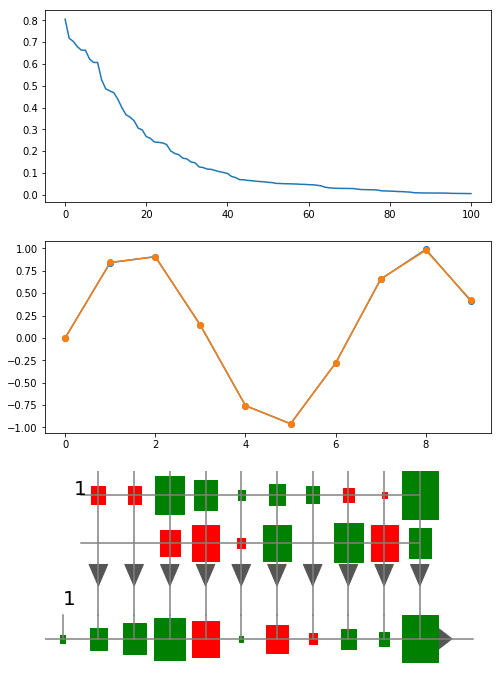

In [23]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(nnetTanh.getErrors())

plt.subplot(3, 1, 2)
plt.plot(X, T, 'o-', label='Actual')
plt.plot(X, nnetTanh.use(X), 'o-', label='Predicted')

plt.subplot(3, 1, 3)
nnetTanh.draw()

#### ReLU

In [24]:
nnetReLU = nn.NeuralNetworkReLU(1, [10], 1)

In [25]:
[nnetReLU.activation(s) for s in [-2, -0.5, 0, 0.5, 2]]

[array(0), array(0.), array(0), array(0.5), array(2)]

In [26]:
[nnetReLU.activationDerivative(nnetReLU.activation(s)) for s in [-2, -0.5, 0, 0.5, 2]]

[array(0), array(0.), array(0), array(1.), array(1)]

In [27]:
nnetReLU.train(X, T, 100, verbose=True)
nnetReLU

SCG: Iteration 10 fValue Eval 0.4325158603835263 Scale 0.008192
SCG: Iteration 20 fValue Eval 0.24429523940245987 Scale 0.008192
SCG: Iteration 30 fValue Eval 0.2297805454182861 Scale 0.262144
SCG: Iteration 40 fValue Eval 0.17739361796925576 Scale 0.032768
SCG: Iteration 50 fValue Eval 0.039580396065411624 Scale 0.002048
SCG: Iteration 60 fValue Eval 0.02961491244809287 Scale 2e-06
SCG: Iteration 70 fValue Eval 0.01788093233095206 Scale 1.953125e-09
SCG: Iteration 80 fValue Eval 0.006864147923811669 Scale 1.9073486328125e-12
SCG: Iteration 90 fValue Eval 0.002037628611155773 Scale 1.862645149230957e-15
SCG: Iteration 100 fValue Eval 0.0005606051814202541 Scale 1e-15


NeuralNetwork(1, [10], 1)
   Network was trained for 101 iterations that took 0.0248 seconds. Final error is 0.023677102470958184.

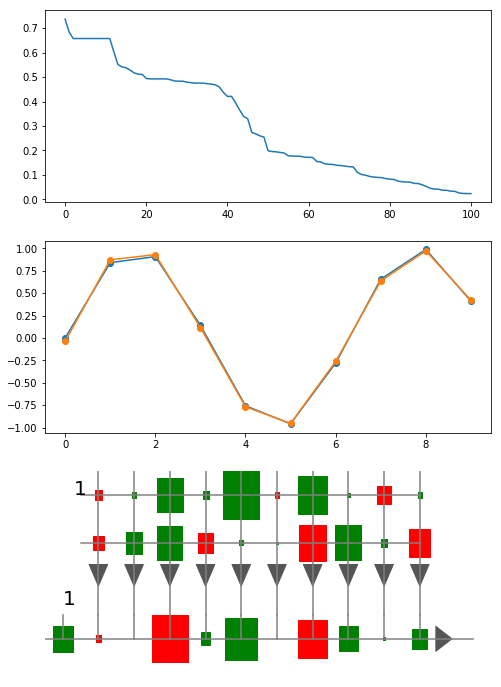

In [28]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(nnetReLU.getErrors())

plt.subplot(3, 1, 2)
plt.plot(X, T, 'o-', label='Actual')
plt.plot(X, nnetReLU.use(X), 'o-', label='Predicted')

plt.subplot(3, 1, 3)
nnetReLU.draw()

## Integration With Our Data 

Using some helper functions and partition (defined above), we are then able to take our fully parsed data set and partition it into training and testing data. We can then simply feed this new data set into the fuctions exactly like the toy data above. 

In [29]:
import numpy as np
import ast
import json
import subprocess
import os
import time
import matplotlib.pyplot as plt
import copy
import mlutils as ml2

In [7]:
# returns the data from the txt file given to it also returns format of data
# requires filename in. 
def readDataFromFile(fileName):
    dataFile = []
    formatFile = []
    temp = ""
    with open(fileName) as f:
        for curline in f:
            if curline.startswith("#"):
                formatFile.append(curline)
            else:
                temp+=curline
    dataFile = ast.literal_eval(temp)
    return dataFile, formatFile

In [8]:
def changeToInt(nparr,col):
    temp = {}
    tempInt = 0
    for x in nparr[:,col]:
        if x not in temp:
            temp[x] = tempInt
            tempInt = tempInt+1
    return temp
        

In [9]:
def replace_with_dict(ar, col, dic):
    for (x,y), value in np.ndenumerate(ar):
        if y == col:
            ar[x,y]=dic.get(ar[x,y])
    print(ar)
    return ar

In [10]:
data, f = readDataFromFile('data list.txt')
npData = np.array(data)

In [11]:
dic =changeToInt(npData,0)
battlefieldDic = changeToInt(npData,1)
characterDic = changeToInt(npData,2)

In [12]:
dic

{'WIN': 0, 'LOSS': 1}

In [13]:
battlefieldDic

{'Alterac Pass': 0,
 'Tomb of the Spider Queen': 1,
 'Battlefield of Eternity': 2,
 "Blackheart's Bay": 3,
 'Braxis Holdout': 4,
 'Dragon Shire': 5,
 'Cursed Hollow': 6,
 'Garden of Terror': 7,
 'Hanamura Temple': 8,
 'Haunted Mines': 9,
 'Infernal Shrines': 10,
 'Lost Cavern': 11,
 'Sky Temple': 12,
 'Towers of Doom': 13,
 'Volskaya Foundry': 14,
 'Warhead Junction': 15}

In [14]:
characterDic

{'Muradin': 0,
 'Li-Ming': 1,
 'Raynor': 2,
 'Garrosh': 3,
 'Fenix': 4,
 'Blaze': 5,
 'Dehaka': 6,
 'Malfurion': 7,
 'Diablo': 8,
 'Jaina': 9,
 'Malthael': 10,
 'Zeratul': 11,
 'Probius': 12,
 'Hanzo': 13,
 'Junkrat': 14,
 "Kel'Thuzad": 15,
 'E.T.C.': 16,
 'Abathur': 17,
 'Greymane': 18,
 'Stitches': 19,
 'Medivh': 20,
 'Uther': 21,
 'Zagara': 22,
 "Mal'Ganis": 23,
 'Genji': 24,
 'Zarya': 25,
 'Sylvanas': 26,
 'Ana': 27,
 'The Butcher': 28,
 'Stukov': 29,
 'Illidan': 30,
 'Arthas': 31,
 'Gall': 32,
 'Ragnaros': 33,
 "Anub'arak": 34,
 'Kharazim': 35,
 'Chromie': 36,
 'Sonya': 37,
 'Maiev': 38,
 'Artanis': 39,
 'Alarak': 40,
 'Mephisto': 41,
 "Kael'thas": 42,
 'Auriel': 43,
 'Yrel': 44,
 "Gul'dan": 45,
 'Valla': 46,
 'Whitemane': 47,
 'Deckard': 48,
 'Azmodan': 49,
 'Johanna': 50,
 'Brightwing': 51,
 'Tracer': 52,
 'Tassadar': 53,
 'Lt. Morales': 54,
 'D.Va': 55,
 'Sgt. Hammer': 56,
 'Alexstrasza': 57,
 'Tyrande': 58}

In [15]:
replace_with_dict(npData,0,dic)
replace_with_dict(npData,1,battlefieldDic)
replace_with_dict(npData,2,characterDic)

[['0' 'Alterac Pass' 'Muradin' ... '40157' '40637' '3']
 ['0' 'Alterac Pass' 'Li-Ming' ... '37477' '70406' '2']
 ['0' 'Alterac Pass' 'Raynor' ... '37744' '45956' '0']
 ...
 ['1' 'Warhead Junction' 'Malfurion' ... '28897' '23253' '0']
 ['1' 'Warhead Junction' 'E.T.C.' ... '25607' '27842' '3']
 ['0' 'Warhead Junction' 'Greymane' ... '30796' '26535' '0']]
[['0' '0' 'Muradin' ... '40157' '40637' '3']
 ['0' '0' 'Li-Ming' ... '37477' '70406' '2']
 ['0' '0' 'Raynor' ... '37744' '45956' '0']
 ...
 ['1' '15' 'Malfurion' ... '28897' '23253' '0']
 ['1' '15' 'E.T.C.' ... '25607' '27842' '3']
 ['0' '15' 'Greymane' ... '30796' '26535' '0']]
[['0' '0' '0' ... '40157' '40637' '3']
 ['0' '0' '1' ... '37477' '70406' '2']
 ['0' '0' '2' ... '37744' '45956' '0']
 ...
 ['1' '15' '7' ... '28897' '23253' '0']
 ['1' '15' '16' ... '25607' '27842' '3']
 ['0' '15' '18' ... '30796' '26535' '0']]


array([['0', '0', '0', ..., '40157', '40637', '3'],
       ['0', '0', '1', ..., '37477', '70406', '2'],
       ['0', '0', '2', ..., '37744', '45956', '0'],
       ...,
       ['1', '15', '7', ..., '28897', '23253', '0'],
       ['1', '15', '16', ..., '25607', '27842', '3'],
       ['0', '15', '18', ..., '30796', '26535', '0']], dtype='<U24')

In [16]:
X = npData[:,1:9]
X = X.astype(int)
T = npData[:,0]
T = T.astype(int)
T = np.vstack(T)

In [160]:
X[1]

array([    0,     1,    21,     1, 64593, 37477, 70406,     2])

In [155]:
npData[1]

array(['0', '0', '1', '21', '1', '64593', '37477', '70406', '2'],
      dtype='<U24')

In [161]:
X2 = npData[:,1:9]
X2 = X2.astype(int)
X2[1]

array([    0,     1,    21,     1, 64593, 37477, 70406,     2])

In [162]:
X.shape

(442, 8)

In [163]:
T.shape

(442, 1)

In [17]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=False)

In [165]:
Xtrain

array([[    0,     0,    19, ..., 40157, 40637,     3],
       [    0,     1,    21, ..., 37477, 70406,     2],
       [    0,     2,    14, ..., 37744, 45956,     0],
       ...,
       [   13,    40,    19, ..., 18123, 41027,     0],
       [   13,     8,    16, ..., 38760, 53761,     2],
       [   13,    17,     9, ..., 58538, 21159,     0]])

In [166]:
Ttrain

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

## Something

Now that we are sure our data has been partitioned and everything is working as intended, we are able to run the experiment. 

A Root Mean Squared Error function is required in order to intrepret the data and truly understand what is happening. 

In [18]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

This python code then performs the following algorithm, for each activation function tanh and ReLU

* For each of the two activation functions, tanh, and ReLU:
    * For each hidden layer structure in [[u]*nl for u in [1, 2, 5, 10, 50] for nl in [1, 2, 3, 4, 5, 10]]:
        * Repeat 10 times:
            * Randomly partition the data into training set with 80% of samples and testing set with other 20%.
            * Create a neural network using the given activation function and hidden layer structure.
            * Train the network for 100 iterations.
            * Calculate two RMS errors, one on the training partition and one on the testing partitions.
        * Calculate the mean of the training and testing RMS errors over the 10 repetitions.

In [167]:
errorsTanh = []
errorsReLU = []
hiddens = [0] + [[nu] * nl for nu in [1, 2, 5, 10, 50] for nl in [1,2,3,4,5,10]]
rmseTrain = 0
rmseTest = 0
print('hiddens =', hiddens)
# tanh activation function
for hids in hiddens: 
    for count in range(0,10):
        Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True)
        nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, 100)
        rmseTrain += rmse(Ttrain, nnet.use(Xtrain))
        rmseTest += rmse(Ttest, nnet.use(Xtest))
    errorsTanh.append([hids, (rmseTrain/10), (rmseTest/10)])
    rmseTrain = 0
    rmseTest = 0
# ReLU activation function
rmseTrain = 0
rmseTest = 0
for hids in hiddens: 
    for count in range(0,10):
        Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True)
        nnet = nn.NeuralNetworkReLU(Xtrain.shape[1], hids, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, 100)
        rmseTrain += rmse(Ttrain, nnet.use(Xtrain))
        rmseTest += rmse(Ttest, nnet.use(Xtest))
    errorsReLU.append([hids, (rmseTrain/10), (rmseTest/10)])
    rmseTrain = 0
    rmseTest = 0
# use panda to print things in a nice format
errorsTanh = pd.DataFrame(errorsTanh)
errorsReLU = pd.DataFrame(errorsReLU)
print('=-=-=-=-tanh-=-=-=-=')
print(errorsTanh)
print('=-=-=-=-ReLU-=-=-=-=')
print(errorsReLU)

hiddens = [0, [1], [1, 1], [1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2], [2, 2], [2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [5], [5, 5], [5, 5, 5], [5, 5, 5, 5], [5, 5, 5, 5, 5], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [50], [50, 50], [50, 50, 50], [50, 50, 50, 50], [50, 50, 50, 50, 50], [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]]
=-=-=-=-tanh-=-=-=-=
                                           0         1         2
0                                          0  0.326501  0.343728
1                                        [1]  0.288126  0.276018
2                                     [1, 1]  0.283649  0.301104
3                                  [1, 1, 1]  0.279869  0.324627
4                               [1, 1, 1, 1]  0.284179  0.296122
5                            [1, 1, 1, 1, 1]  0.281725  0.331065
6             [1, 1, 1, 1

That is a little confusing, so we plotted our results to be able to better see and intrepret the information:

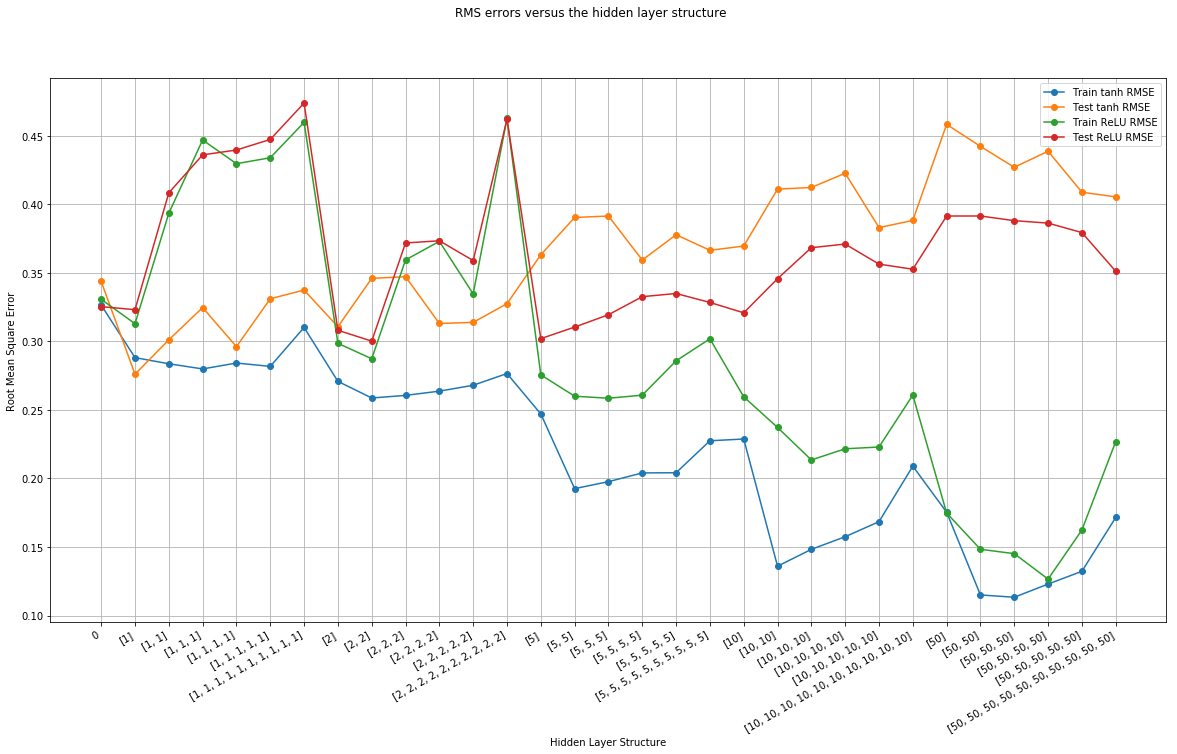

In [168]:
plt.figure(figsize=(20, 10))
plt.plot(errorsTanh.values[:, 1:], 'o-')
plt.plot(errorsReLU.values[:, 1:], 'o-')
plt.suptitle('RMS errors versus the hidden layer structure')
plt.legend(('Train tanh RMSE', 'Test tanh RMSE', 'Train ReLU RMSE', 'Test ReLU RMSE'))
plt.xlabel('Hidden Layer Structure')
plt.ylabel('Root Mean Square Error')
plt.xticks(range(errorsTanh.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)

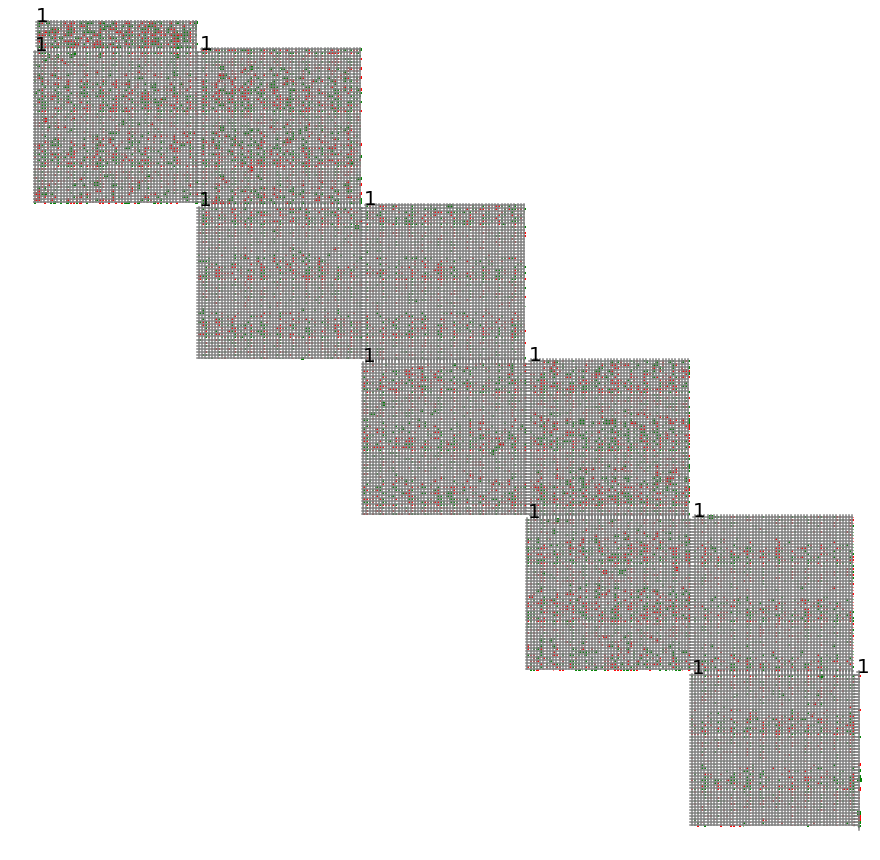

In [169]:
plt.figure(figsize=(15, 15))
nnet.draw()

In [170]:
nnet2 = nn.NeuralNetworkReLU(Xtrain.shape[1], [40], Ttrain.shape[1])
nnet2.train(Xtrain, Ttrain, 10000)

NeuralNetwork(8, [40], 1)
   Network was trained for 10001 iterations that took 12.6734 seconds. Final error is 0.209278141468406.

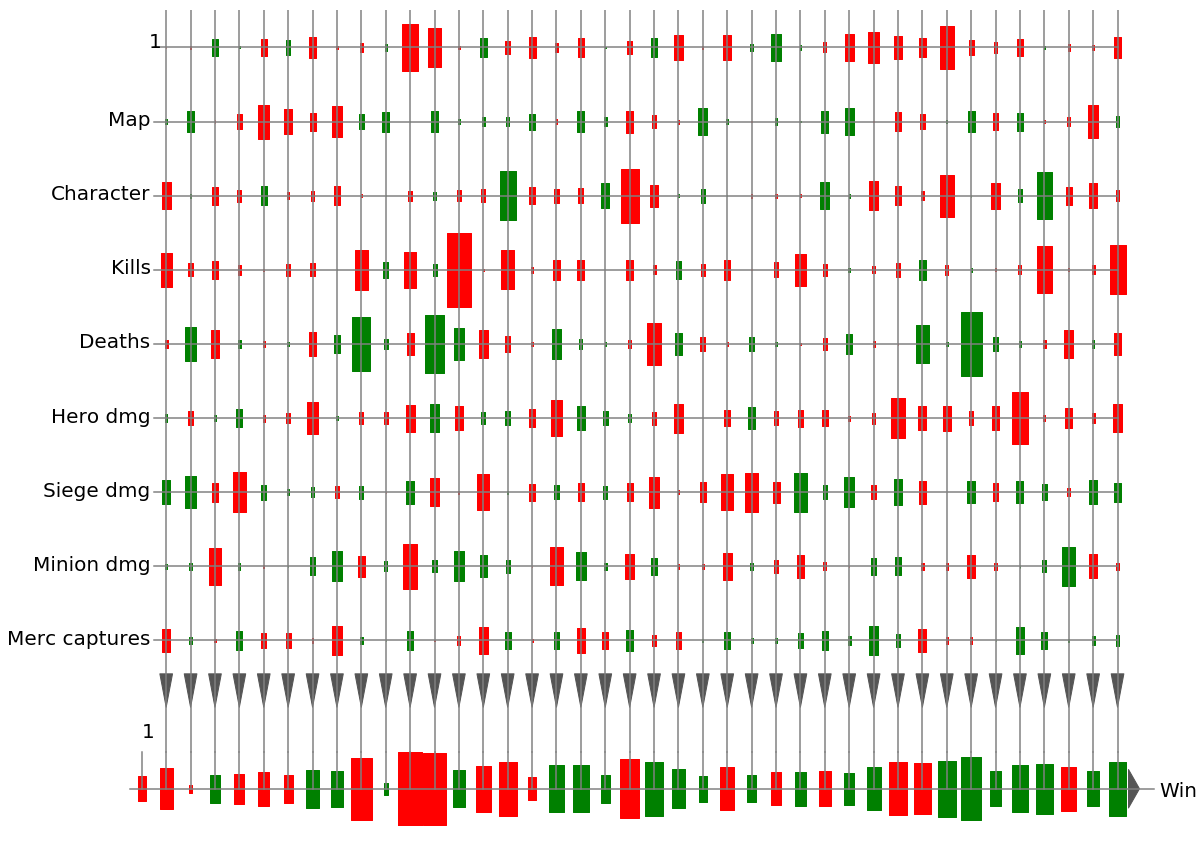

In [171]:
plt.figure(figsize=(20, 15))
nnet2.draw(['Map','Character','Kills','Deaths','Hero dmg','Siege dmg','Minion dmg','Merc captures'],['Win'])

In [177]:
Xtrain.shape[1]

8

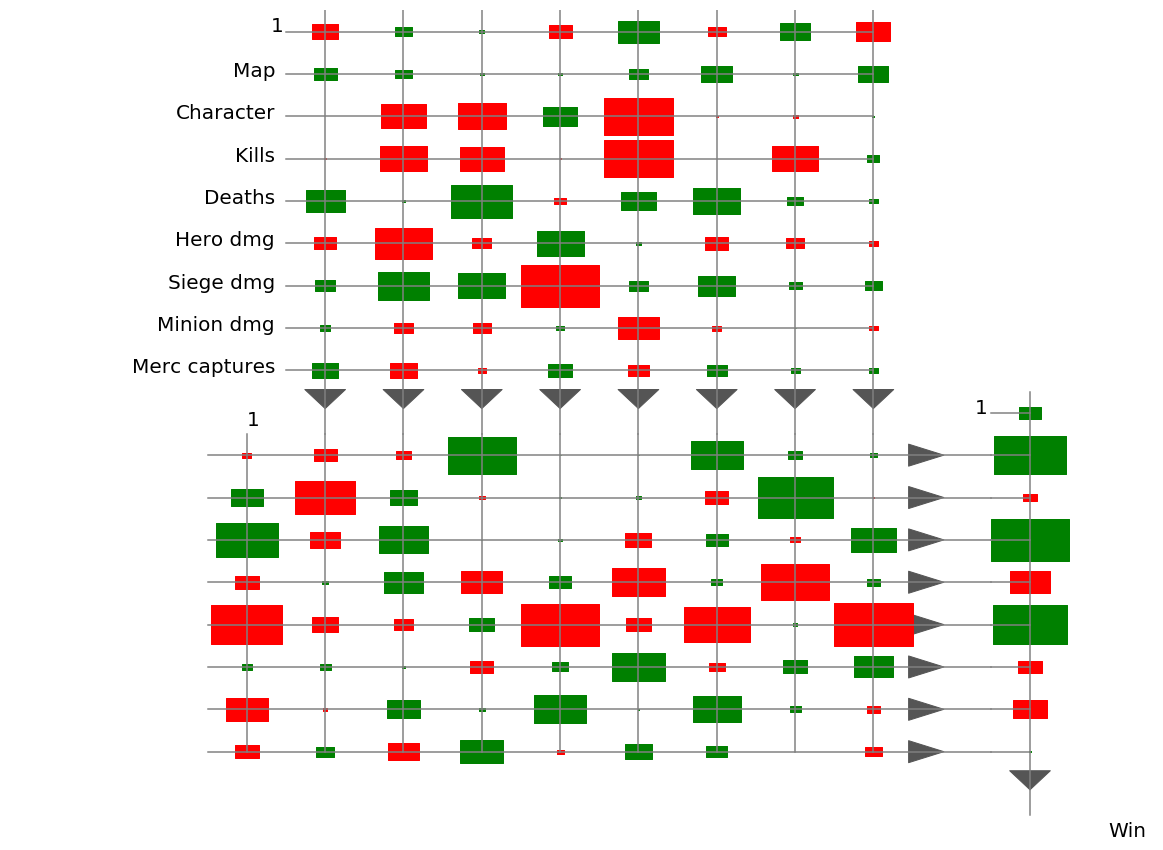

In [19]:
nnet3 = nn.NeuralNetworkReLU(Xtrain.shape[1], [8,8], Ttrain.shape[1])
nnet3.train(Xtrain, Ttrain, 1000)
plt.figure(figsize=(20, 15))
nnet3.draw(['Map','Character','Kills','Deaths','Hero dmg','Siege dmg','Minion dmg','Merc captures'],['Win'])

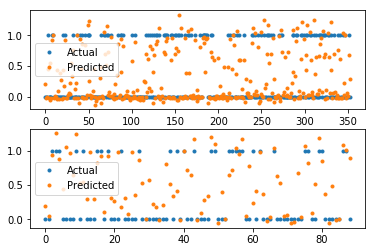

In [31]:
Ptrain,Prtrain = nnet3.use(Xtrain,allOutputs=True)
Ptest,Prtest = nnet3.use(Xtest,allOutputs=True)
plt.subplot(2,1,1)
plt.plot(np.hstack((Ttrain,Ptrain)), '.')
plt.legend(('Actual','Predicted'))
plt.subplot(2,1,2)
plt.plot(np.hstack((Ttest,Ptest)), '.')
plt.legend(('Actual','Predicted'));

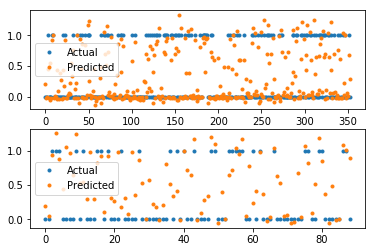

In [35]:
Ptrain,Prtrain = nnet3.use(Xtrain,allOutputs=True)
Ptest,Prtest = nnet3.use(Xtest,allOutputs=True)
plt.subplot(2,1,1)
plt.plot(np.hstack((Ttrain,Ptrain)), '.')
plt.legend(('Actual','Predicted'))
plt.subplot(2,1,2)
plt.plot(np.hstack((Ttest,Ptest)), '.')
plt.legend(('Actual','Predicted'));

## Tanh

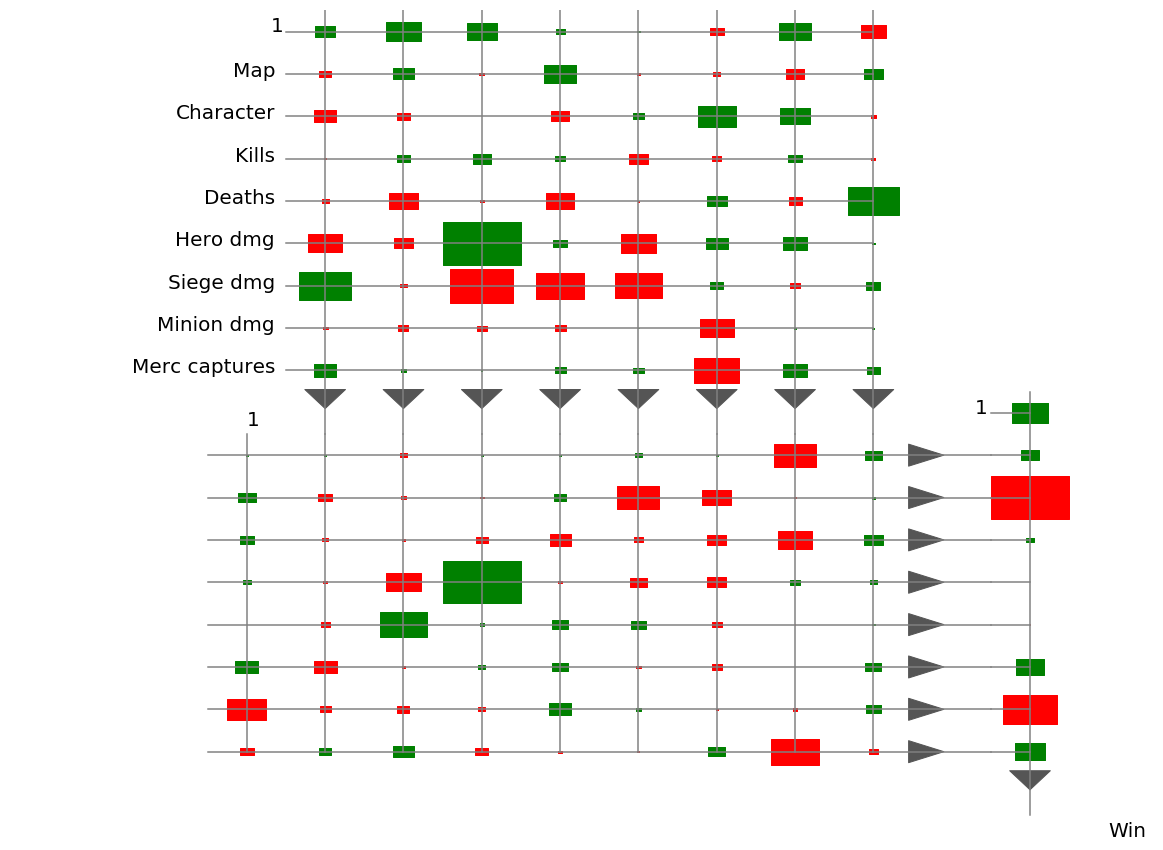

In [52]:
nnet4 = nn.NeuralNetwork(Xtrain.shape[1], [8,8], Ttrain.shape[1])
nnet4.train(Xtrain, Ttrain, 1000)
plt.figure(figsize=(20, 15))
nnet4.draw(['Map','Character','Kills','Deaths','Hero dmg','Siege dmg','Minion dmg','Merc captures'],['Win'])

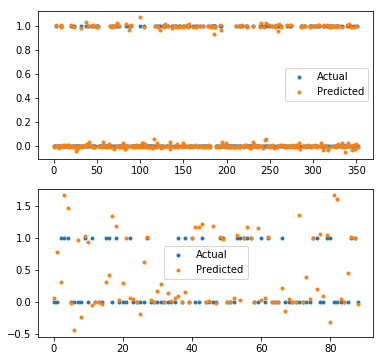

In [53]:
Ptrain,Prtrain = nnet4.use(Xtrain,allOutputs=True)
Ptest,Prtest = nnet4.use(Xtest,allOutputs=True)
plt.subplot(2,1,1)
plt.plot(np.hstack((Ttrain,Ptrain)), '.')
plt.legend(('Actual','Predicted'))
plt.subplot(2,1,2)
plt.plot(np.hstack((Ttest,Ptest)), '.')
plt.legend(('Actual','Predicted'));

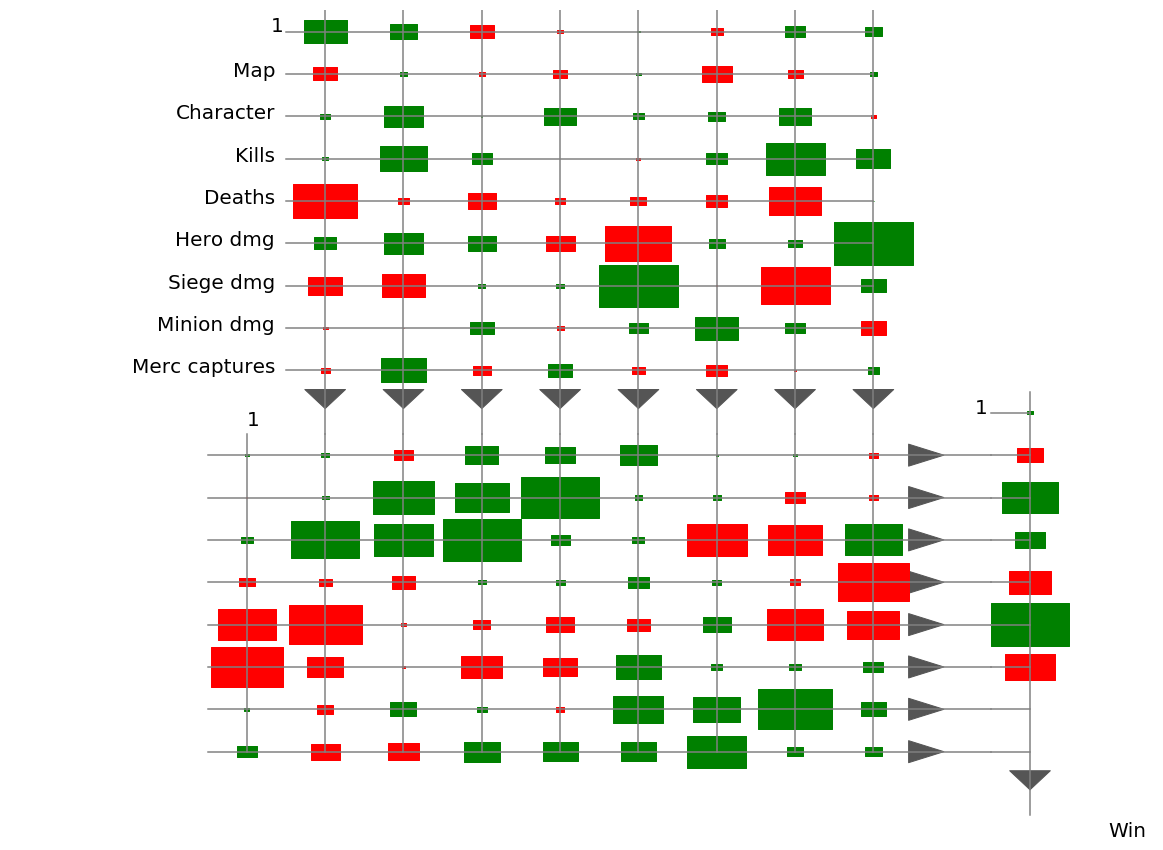

In [58]:
nnet5 = nn.NeuralNetwork(Xtrain.shape[1], [8,8], Ttrain.shape[1])
nnet5.train(Xtrain, Ttrain, 10000)
plt.figure(figsize=(20, 15))
nnet5.draw(['Map','Character','Kills','Deaths','Hero dmg','Siege dmg','Minion dmg','Merc captures'],['Win'])

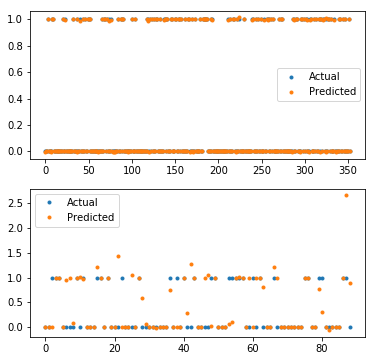

In [59]:
Ptrain,Prtrain = nnet5.use(Xtrain,allOutputs=True)
Ptest,Prtest = nnet5.use(Xtest,allOutputs=True)
plt.subplot(2,1,1)
plt.plot(np.hstack((Ttrain,Ptrain)), '.')
plt.legend(('Actual','Predicted'))
plt.subplot(2,1,2)
plt.plot(np.hstack((Ttest,Ptest)), '.')
plt.legend(('Actual','Predicted'));

In [62]:
import mlutils as ml2
cm = ml2.confusionMatrix(Ttrain,Ptrain,np.unique(Ttrain))
print('1-Map 2-Character 3-Kills 4-Deaths Hero dmg 5-Siege dmg 6-Minion dmg 7-Merc captures')


1-Map 2-Character 3-Kills 4-Deaths Hero dmg 5-Siege dmg 6-Minion dmg 7-Merc captures


In [63]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('NeuralNetworks.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)



Word count for file NeuralNetworks.ipynb is 725


### Results

stub